In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython import display
import time
from tqdm import tqdm

from utils import BadgerAgent, MultitaskAgent, AttentionLayer
from math import *

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = "cpu"

In [2]:
# Define ImageTask - agent has to guess DIM numbers based on MSE error (aggregated for all the numbers)

class ImageTask():
    def __init__(self, BS=100, DIM=3):
        self.targets = torch.rand(BS, DIM, device=DEVICE) * 2 - 1
        self.last = torch.zeros(BS, DIM, device=DEVICE)
        self.BS = BS
        self.DIM = DIM

    def step(self, agent, out_addr=None):
        err = 3 * torch.mean((self.last - self.targets) ** 2, 1).view(self.BS, 1)
        inp = torch.zeros(BS, 32, 0, device=DEVICE)

        outputs, w, idx = agent.forward(inp, err, output_addr=out_addr)

        self.sublast = self.last
        self.last = outputs
        self.outputs = outputs

        return torch.mean(err), w, idx

    def train(self, agent, out_addr=None):
        interval = 20

        for i in range(interval):
            err, w, idx = self.step(agent, out_addr)

        return err

# Check chance level for image task
def check_chance_level(dim):
    targets = np.random.rand(10000, dim) * 2 - 1
    guess = np.zeros_like(targets)
    print("Chance level (d=%s): %.6g" % (dim, 3 * np.mean((targets - guess) ** 2)))

check_chance_level(3)
check_chance_level(6)

Chance level (d=3): 0.997121
Chance level (d=6): 1.00189


In [3]:
# Create agent
agent = MultitaskAgent(N_INPUTS=0, KEY=32, INPUT_CHUNK=32, HIDDEN=64).to(DEVICE)
# agent.load_state_dict(torch.load("checkpoint3.pth"))

for p in agent.optim.param_groups:
    p['lr'] = 1e-4

BS = 100
tr_err = []

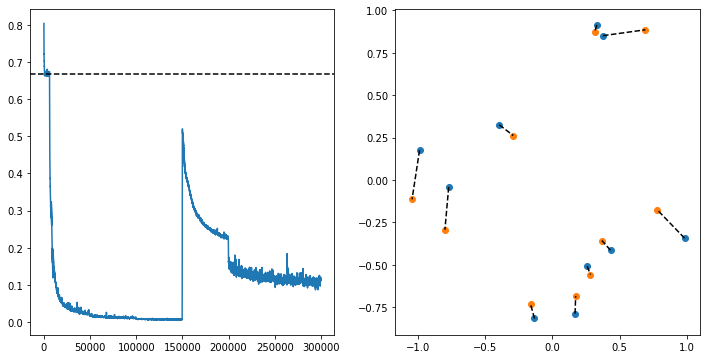

100%|██████████| 300000/300000 [14:31:54<00:00,  5.73it/s]


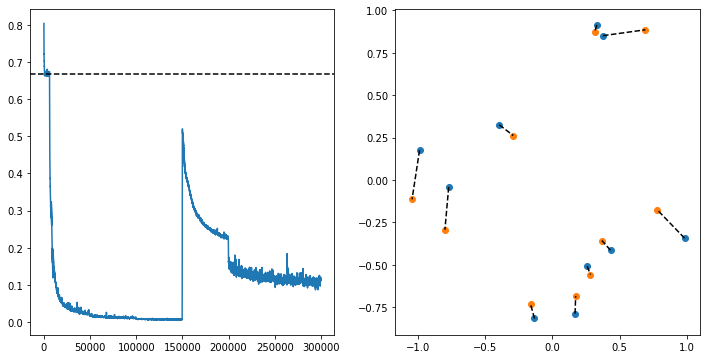

In [5]:
# Learning loop

N_EXPERTS = 20
DIM = 3

for epoch in tqdm(range(0, 300000)):
    # Lower learning rate at 50k, 100k
    if epoch == 50000 - 1:
        for p in agent.optim.param_groups:
            p['lr'] = 5e-5
    if epoch == 100000 - 1:
        for p in agent.optim.param_groups:
            p['lr'] = 2e-5

    if epoch == 150000 - 1:  # Make first checkpoint, change dimensionality here
        torch.save(agent.state_dict(), open("data/rout_checkpoint1.pth", "wb"))
        DIM = 6

    if epoch == 200000 - 1:  # Make second checkpoint
        torch.save(agent.state_dict(), open("data/rout_checkpoint2.pth", "wb"))

    # Beyond 200k, randomize dimension and # experts every step
    if epoch >= 200000 - 1:
        DIM = 3 + np.random.randint(4)
        N_EXPERTS = 5 + np.random.randint(36)

    # For the first 10k epochs, use fixed output addresses for 2k epochs at a time
    if epoch < 10000:
        if epoch % 2000 == 0:
            out_addr = torch.randn(BS, 1, DIM, 16).to(DEVICE)
    else:  # Then randomize every time
        out_addr = torch.randn(BS, 1, DIM, 16).to(DEVICE)

    agent.optim.zero_grad()

    errs = []

    agent.init_rollout(BS=BS, N_EXPERTS=N_EXPERTS, N_OUTPUTS=DIM)
    task = ImageTask(BS=BS, DIM=DIM)
    err = task.train(agent, out_addr)

    # Lets try without this trick
    # sl = task.sublast - torch.mean(task.sublast,0).unsqueeze(0)
    # reg = torch.clamp(torch.std(sl,1),0,0.5).mean()
    # loss = err - 0.0 * reg

    loss = err
    loss.backward()

    errs.append(err.cpu().detach().item())

    agent.optim.step()

    tr_err.append(np.mean(errs))

    if epoch % 50 == 0:
        cs = np.cumsum(tr_err)
        cs = (cs[250:] - cs[:-250]) / 250.0

        plt.clf()
        plt.subplot(1, 2, 1)
        plt.plot(cs)
        plt.axhline(allavg[2], c='k', ls='--')

        plt.subplot(1, 2, 2)
        targs = task.targets.cpu().detach().numpy()
        last = task.sublast.cpu().detach().numpy()
        plt.scatter(targs[:10, 0], targs[:10, 1])
        plt.scatter(last[:10, 0], last[:10, 1])
        plt.plot([targs[:10, 0], last[:10, 0]], [targs[:10, 1], last[:10, 1]], 'k--')

        plt.gcf().set_size_inches((12, 6))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)

        torch.save(agent.state_dict(), open("data/training.pth", "wb"))

torch.save(agent.state_dict(), open("data/rout_checkpoint3.pth", "wb"))

In [4]:
def baseline(DIM):
    # Set all dimensions to average
    targets = np.random.rand(10000, DIM) * 2 - 1
    guess = np.mean(targets, axis=1, keepdims=True)
    return 3 * np.mean((targets - guess) ** 2)

def run_inference(N_EXPERTS, DIM):
    avg_error = 0
    for j in range(10):
        with torch.no_grad():
            out_addr = torch.randn(BS, 1, DIM, 16).to(DEVICE)
            agent.init_rollout(BS=BS, N_EXPERTS=N_EXPERTS, N_OUTPUTS=DIM)
            task = ImageTask(BS=BS, DIM=DIM)

            for i in range(20):
                err, w, idx = task.step(agent, out_addr=out_addr)
            avg_error += err.cpu().detach().item()
    return avg_error / 10.0

In [5]:
# Testing on different DIMs
DIMS = range(1,21)

# Compute baseline - loss for agent responding with average values
allavg = [baseline(dim) for dim in DIMS]

# 150k epochs of learning on 3 dimensions
agent.load_state_dict(torch.load("data/rout_checkpoint1.pth"))
errs1 = [run_inference(N_EXPERTS=20, DIM=dim) for dim in DIMS]

# 200k epochs of learning on 3 and 6 dimensions
agent.load_state_dict(torch.load("data/rout_checkpoint2.pth"))
errs2 = [run_inference(N_EXPERTS=20, DIM=dim) for dim in DIMS]

# 300k epochs of learning on 3 and 6 dimensions
agent.load_state_dict(torch.load("data/rout_checkpoint3.pth"))
errs5 = [run_inference(N_EXPERTS=20, DIM=dim) for dim in DIMS]

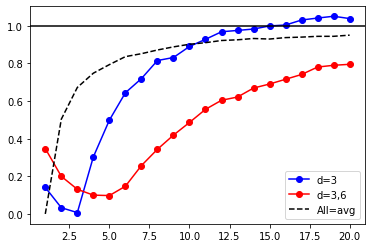

In [6]:
# At this point, it has been trained on d=3  - 200k epochs of learning
# Chance level is around 1.0
# 'set all dimensions equal' is around 0.38

plt.plot(DIMS, errs1, 'bo-', label="d=3")
plt.plot(DIMS, errs2, 'ro-', label="d=3,6")
plt.plot(DIMS, allavg, 'k--', label="All=avg")
plt.axhline(1.0, c='k', ls='-')
plt.legend()
plt.show()

In [7]:
# Testing on different number of experts - 300k epochs of learning
EXPERTS = np.arange(1, 81, 5)
DIM = 6

agent.load_state_dict(torch.load("data/rout_checkpoint2.pth"))
errs3 = [run_inference(N_EXPERTS=experts, DIM=DIM) for experts in EXPERTS]
agent.load_state_dict(torch.load("data/rout_checkpoint3.pth"))
errs4 = [run_inference(N_EXPERTS=experts, DIM=DIM) for experts in EXPERTS]

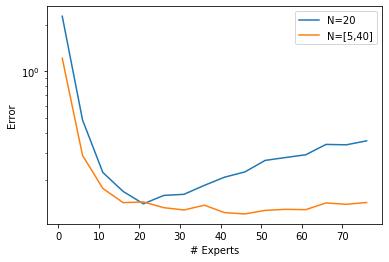

In [8]:
# Plot of different number of experts testing - 200k and 300k epochs of learning

plt.plot(EXPERTS, errs3, label="N=20")
plt.plot(EXPERTS, errs4, label="N=[5,40]")
plt.yscale("log")
plt.xlabel("# Experts")
plt.ylabel("Error")
plt.legend()

plt.savefig("data/figure1.pdf")
plt.show()

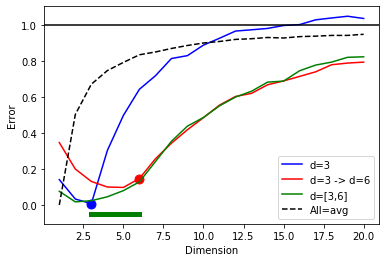

In [9]:
# At this point, it has been trained on d=3
# Chance level is around 1.0
# 'set all dimensions equal' is around 0.38

plt.plot(DIMS, errs1, 'b-', label="d=3")
plt.scatter(3, errs1[2], s=80, c='b')
plt.plot(DIMS, errs2, 'r-', label="d=3 -> d=6")
plt.scatter(6, errs2[5], s=80, c='r')
plt.plot(DIMS, errs5, 'g-', label="d=[3,6]")
plt.plot([3, 6], [-0.05, -0.05], 'g-', lw=5)
plt.plot(DIMS, allavg, 'k--', label="All=avg")
plt.axhline(1.0, c='k', ls='-')
plt.legend()
plt.xlabel("Dimension")
plt.ylabel("Error")
plt.savefig("data/figure2.pdf")
plt.show()